# SMDP (Pickup and drop option)

In [1]:
'''
A bunch of imports, you don't have to worry about these
'''
import random
import numpy as np
import random
import gymnasium as gym
import glob
import io
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML
from IPython.display import clear_output
import time

In [2]:
#Setting up the environment
env = gym.make('Taxi-v3')

env.reset()

#Current State
print(env.unwrapped.s)

# 5x5x5x4 grid = 500 states
print ("Number of states:", env.unwrapped.observation_space.n)

# Primitive Actions
action = ["south", "north", "east", "west","pick","drop"]
#correspond to [0,1,2,3,4,5] that's actually passed to the environment

# either go left, up, down or right
print ("Number of actions that an agent can take:", env.unwrapped.action_space.n)

# Example Transitions
rnd_action = random.randint(0, 3)
print ("Action taken:", action[rnd_action])
next_state, reward, is_terminal, t_prob, _ = env.step(rnd_action)
print ("Transition probability:", t_prob)
print ("Next state:", next_state)
print ("Reward recieved:", reward)
print ("Terminal state:", is_terminal)

state, _ = env.reset()
print ("Decoded state:", list(env.unwrapped.decode(state)))

449
Number of states: 500
Number of actions that an agent can take: 6
Action taken: east
Transition probability: False
Next state: 449
Reward recieved: -1
Terminal state: False
Decoded state: [3, 0, 0, 1]


In [3]:
policyOptionR = np.array([[1,3,0,0,0],
                 [1,3,0,0,0],
                 [1,3,3,3,3],
                 [1,1,1,1,1],
                 [1,1,1,1,1]
                 ])
policyOptionG = np.array([[0,0,2,2,1],
                 [0,0,2,2,1],
                 [2,2,2,1,1],
                 [1,2,1,1,1],
                 [1,2,1,1,1]
                 ])
policyOptionY = np.array([[0,3,0,0,0],
                          [0,3,0,0,0],
                          [0,3,3,3,3],
                          [0,1,1,1,3],
                          [0,1,3,1,3]
                          ])
policyOptionB = np.array([[0,0,0,0,3],
                          [0,0,0,0,3],
                          [2,2,2,0,3],
                          [1,1,1,0,3],
                          [1,1,1,0,3]
                          ])
policyOpt = [policyOptionR,policyOptionG,policyOptionY,policyOptionB]

In [4]:
# --- Option function for two options: pick and drop ---
def Option(env, state, Q, optionNum, eps=0.1):
    optdone = False
    x, y, pas, drop = env.unwrapped.decode(state)
    locs = env.unwrapped.locs

    if optionNum == 0:  # Pick option
        # If passenger is already in taxi (pas == 4), option is done
        if pas == 4:
            # print("Pickup option is done")
            optdone = True
            optact = egreedy_policy(Q[optionNum], 5*x + y, epsilon=eps)
        else:
            target = locs[pas]
            if (x, y) == target:
                optact = 4  # pick action
                optdone = True
            else:
                # print("drop = ", drop, "x = ", x, "y = ", y)
                optact = policyOpt[pas][x][y]
                # optact = egreedy_policy(Q[optionNum], 5*x + y, epsilon=eps)
    elif optionNum == 1:  # Drop option
        # If passenger is not in taxi, cannot drop
        if pas != 4:
            optdone = True
            optact = egreedy_policy(Q[optionNum], 5*x + y, epsilon=eps)
        else:
            target = locs[drop]
            if (x, y) == target:
                optact = 5  # drop action
                optdone = True
            else:
                # print("drop = ", drop, "x = ", x, "y = ", y)
                optact = policyOpt[drop][x][y]
                # optact = egreedy_policy(Q[optionNum], 5*x + y, epsilon=eps)
    else:
        raise ValueError("Invalid option number")
    return [optact, optdone]

# epsilon-greedy action selection function
def egreedy_policy(q_values,state,epsilon):
  if q_values[state].any() and random.random() > epsilon:
    #print('greedy', np.argmax(q_values[state]),q_values.shape)
    return np.argmax(q_values[state])
  choice = random.randint(0,q_values.shape[-1]-1)  
  #print('random',choice,q_values.shape)  
  return choice

In [5]:
#### SMDP Q-Learning 

from tqdm import tqdm

rewards4 = []
T = 1
goal = {0:[0,0],1:[0,4],2:[4,0],3:[4,3]}

gamma = 0.9
alpha = 0.1
nO = 2 #number of options
nX = 5; nY = 5; nPas = 5; nDrop = 4
q_values_SMDP = np.zeros((nPas*nDrop,nO))
updates_SMDP = np.zeros((nPas*nDrop,nO))

Qopt = {i:np.zeros((env.unwrapped.observation_space.n//20,env.unwrapped.action_space.n)) for i in range(nO)} #Q-values for each option
eps = {i:0.01 for i in range(nO)}
eps_min = 0.01
eps_decay = 0.99
eps_main = 0.9
count = 0
Neps = 5000

# Iterate over Neps episodes
for i in tqdm(range(Neps)):
    state, _ = env.reset()    
    done = False
    tot_rew = 0
    # While episode is not over
    while not done:
        
        # Choose action       
        x,y,pas,drop = env.unwrapped.decode(state) 
        subState = nDrop*pas+drop
        option = egreedy_policy(q_values_SMDP, subState, epsilon=eps_main)
        eps_main = max(eps_min,eps_decay*eps_main)
        reward_bar = 0
        optdone = False
        move = 0
        prev = state  

        #Go to location and drop/pick
        x,y,pas,drop = env.unwrapped.decode(state)
        optdone = False
        while not optdone and not done:
          optact,optdone = Option(env,state,Qopt,option,eps[option])
          
          [x,y,_,_]=  list(env.unwrapped.decode(state))  

          next_state, reward, terminated, truncated,_ = env.step(optact)
          done = terminated or truncated
          [x1,y1,_,_]=  list(env.unwrapped.decode(next_state)) 
          reward_bar = gamma*reward_bar + reward
          move += 1
          tot_rew+=reward

          eps[option] = max(eps_min,eps_decay*eps[option])
          reward_surr = reward
          if optdone:
            reward_surr = 20
          # if optact<4:  
          Qopt[option][5*x+y, optact] = Qopt[option][5*x+y, optact] + alpha*(reward_surr + gamma*np.max(Qopt[option][5*x1+y1, :]) - Qopt[option][5*x+y, optact])
          state = next_state

          

            #--
        _,_,pas,drop = env.unwrapped.decode(state) 
        subState = nDrop*pas+drop

        _,_,pas,drop = env.unwrapped.decode(prev) 
        subPrev = nDrop*pas+drop

        q_values_SMDP[subPrev, option] += alpha*(reward_bar + (gamma**move)*np.max(q_values_SMDP[subState, :]) - q_values_SMDP[subPrev, option])
        updates_SMDP[subPrev, option] += 1
    rewards4.append(tot_rew)
    x,y,pas,drop = env.unwrapped.decode(state)
    if pas==drop:
      count+=1
      clear_output(wait=True)
      # print('Success ({}/{}) = {}%'.format(count,i+1,100*count/(i+1)))
 
        

100%|██████████| 5000/5000 [00:06<00:00, 754.46it/s]


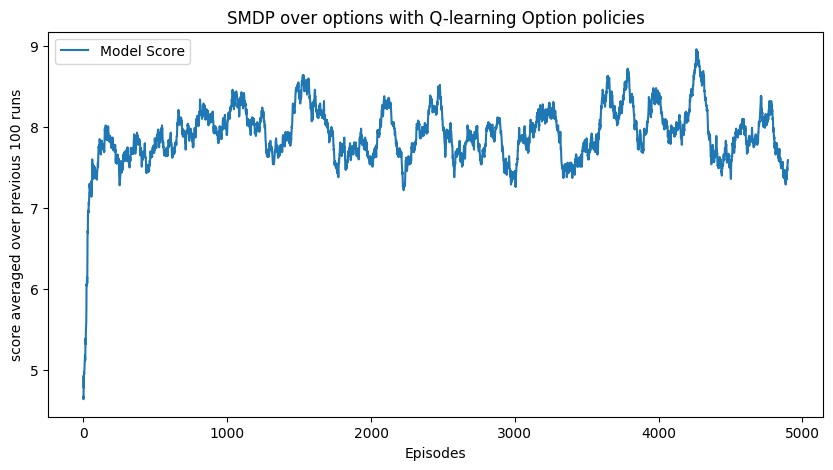

In [6]:
plt.figure(figsize = (10,5))
avg_rews4 = [np.average(rewards4[i:i+100]) for i in range(len(rewards4)-100)]
plt.plot(avg_rews4,label = 'Model Score')
plt.xlabel('Episodes')
plt.ylabel('score averaged over previous 100 runs')
plt.title('SMDP over options with Q-learning Option policies')
plt.legend()

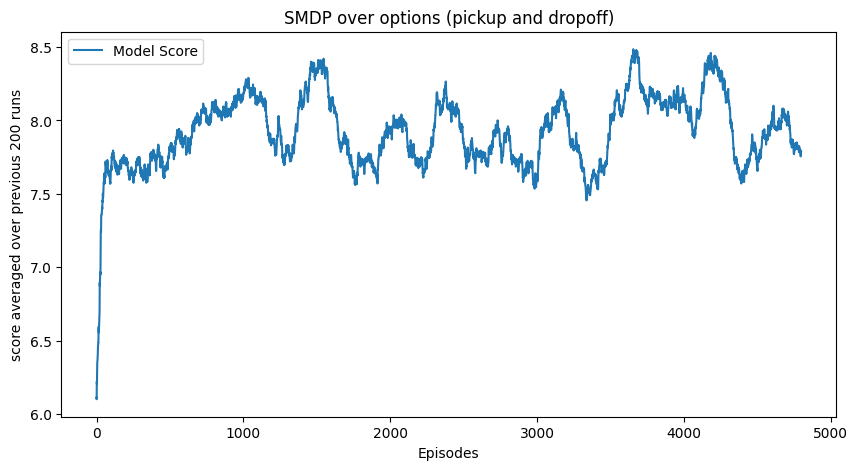

In [7]:
plt.figure(figsize = (10,5))
avg_rews4 = [np.average(rewards4[i:i+200]) for i in range(len(rewards4)-200)]
plt.plot(avg_rews4,label = 'Model Score')
plt.xlabel('Episodes')
plt.ylabel('score averaged over previous 200 runs')
plt.title('SMDP over options (pickup and dropoff)')
plt.legend()

Text(0.5, 1.0, 'Option learnt by SMDP (pickup and dropoff)')

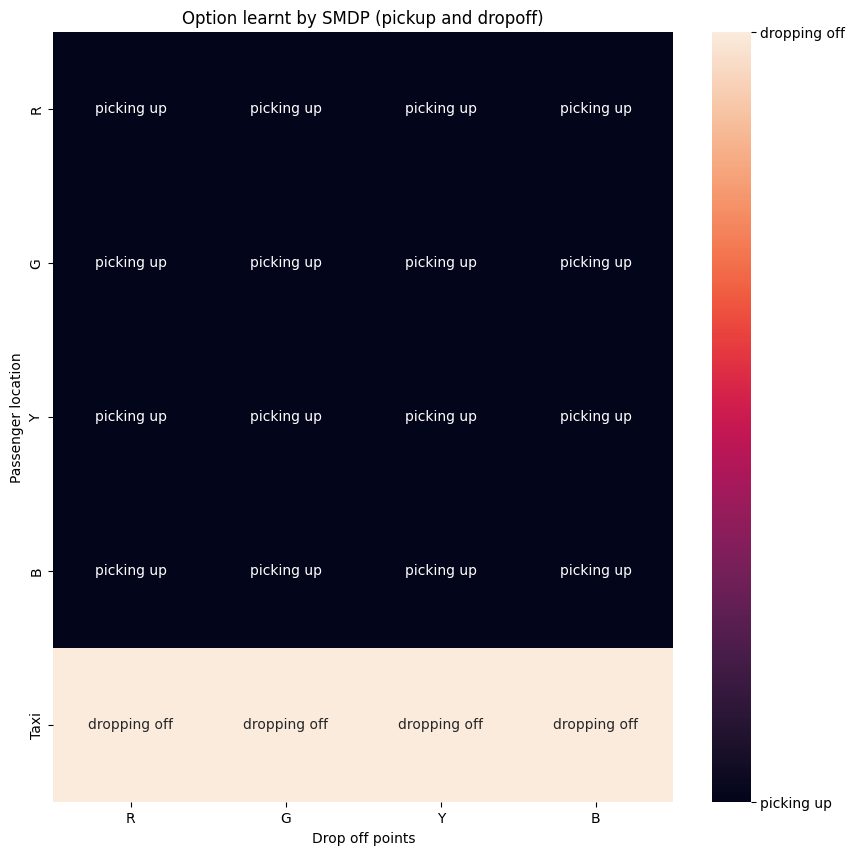

In [8]:
Qmax_SMDP = np.argmax(q_values_SMDP,axis = 1).reshape(5,4)
labels = {0:'picking up',1:'dropping off'}
annot_text = np.vectorize(labels.get)(Qmax_SMDP)
figure, axis = plt.subplots(1, 1,figsize=(10,10))
ax = sns.heatmap(Qmax_SMDP,ax=axis,xticklabels = ["R","G","Y","B"],yticklabels = ['R','G','Y','B','Taxi'],annot = annot_text,fmt = '')
c_bar = ax.collections[0].colorbar
c_bar.set_ticks([0, 1])
c_bar.set_ticklabels(['picking up','dropping off'])

axis.set_xlabel('Drop off points')
axis.set_ylabel("Passenger location")
axis.set_title('Option learnt by SMDP (pickup and dropoff)')

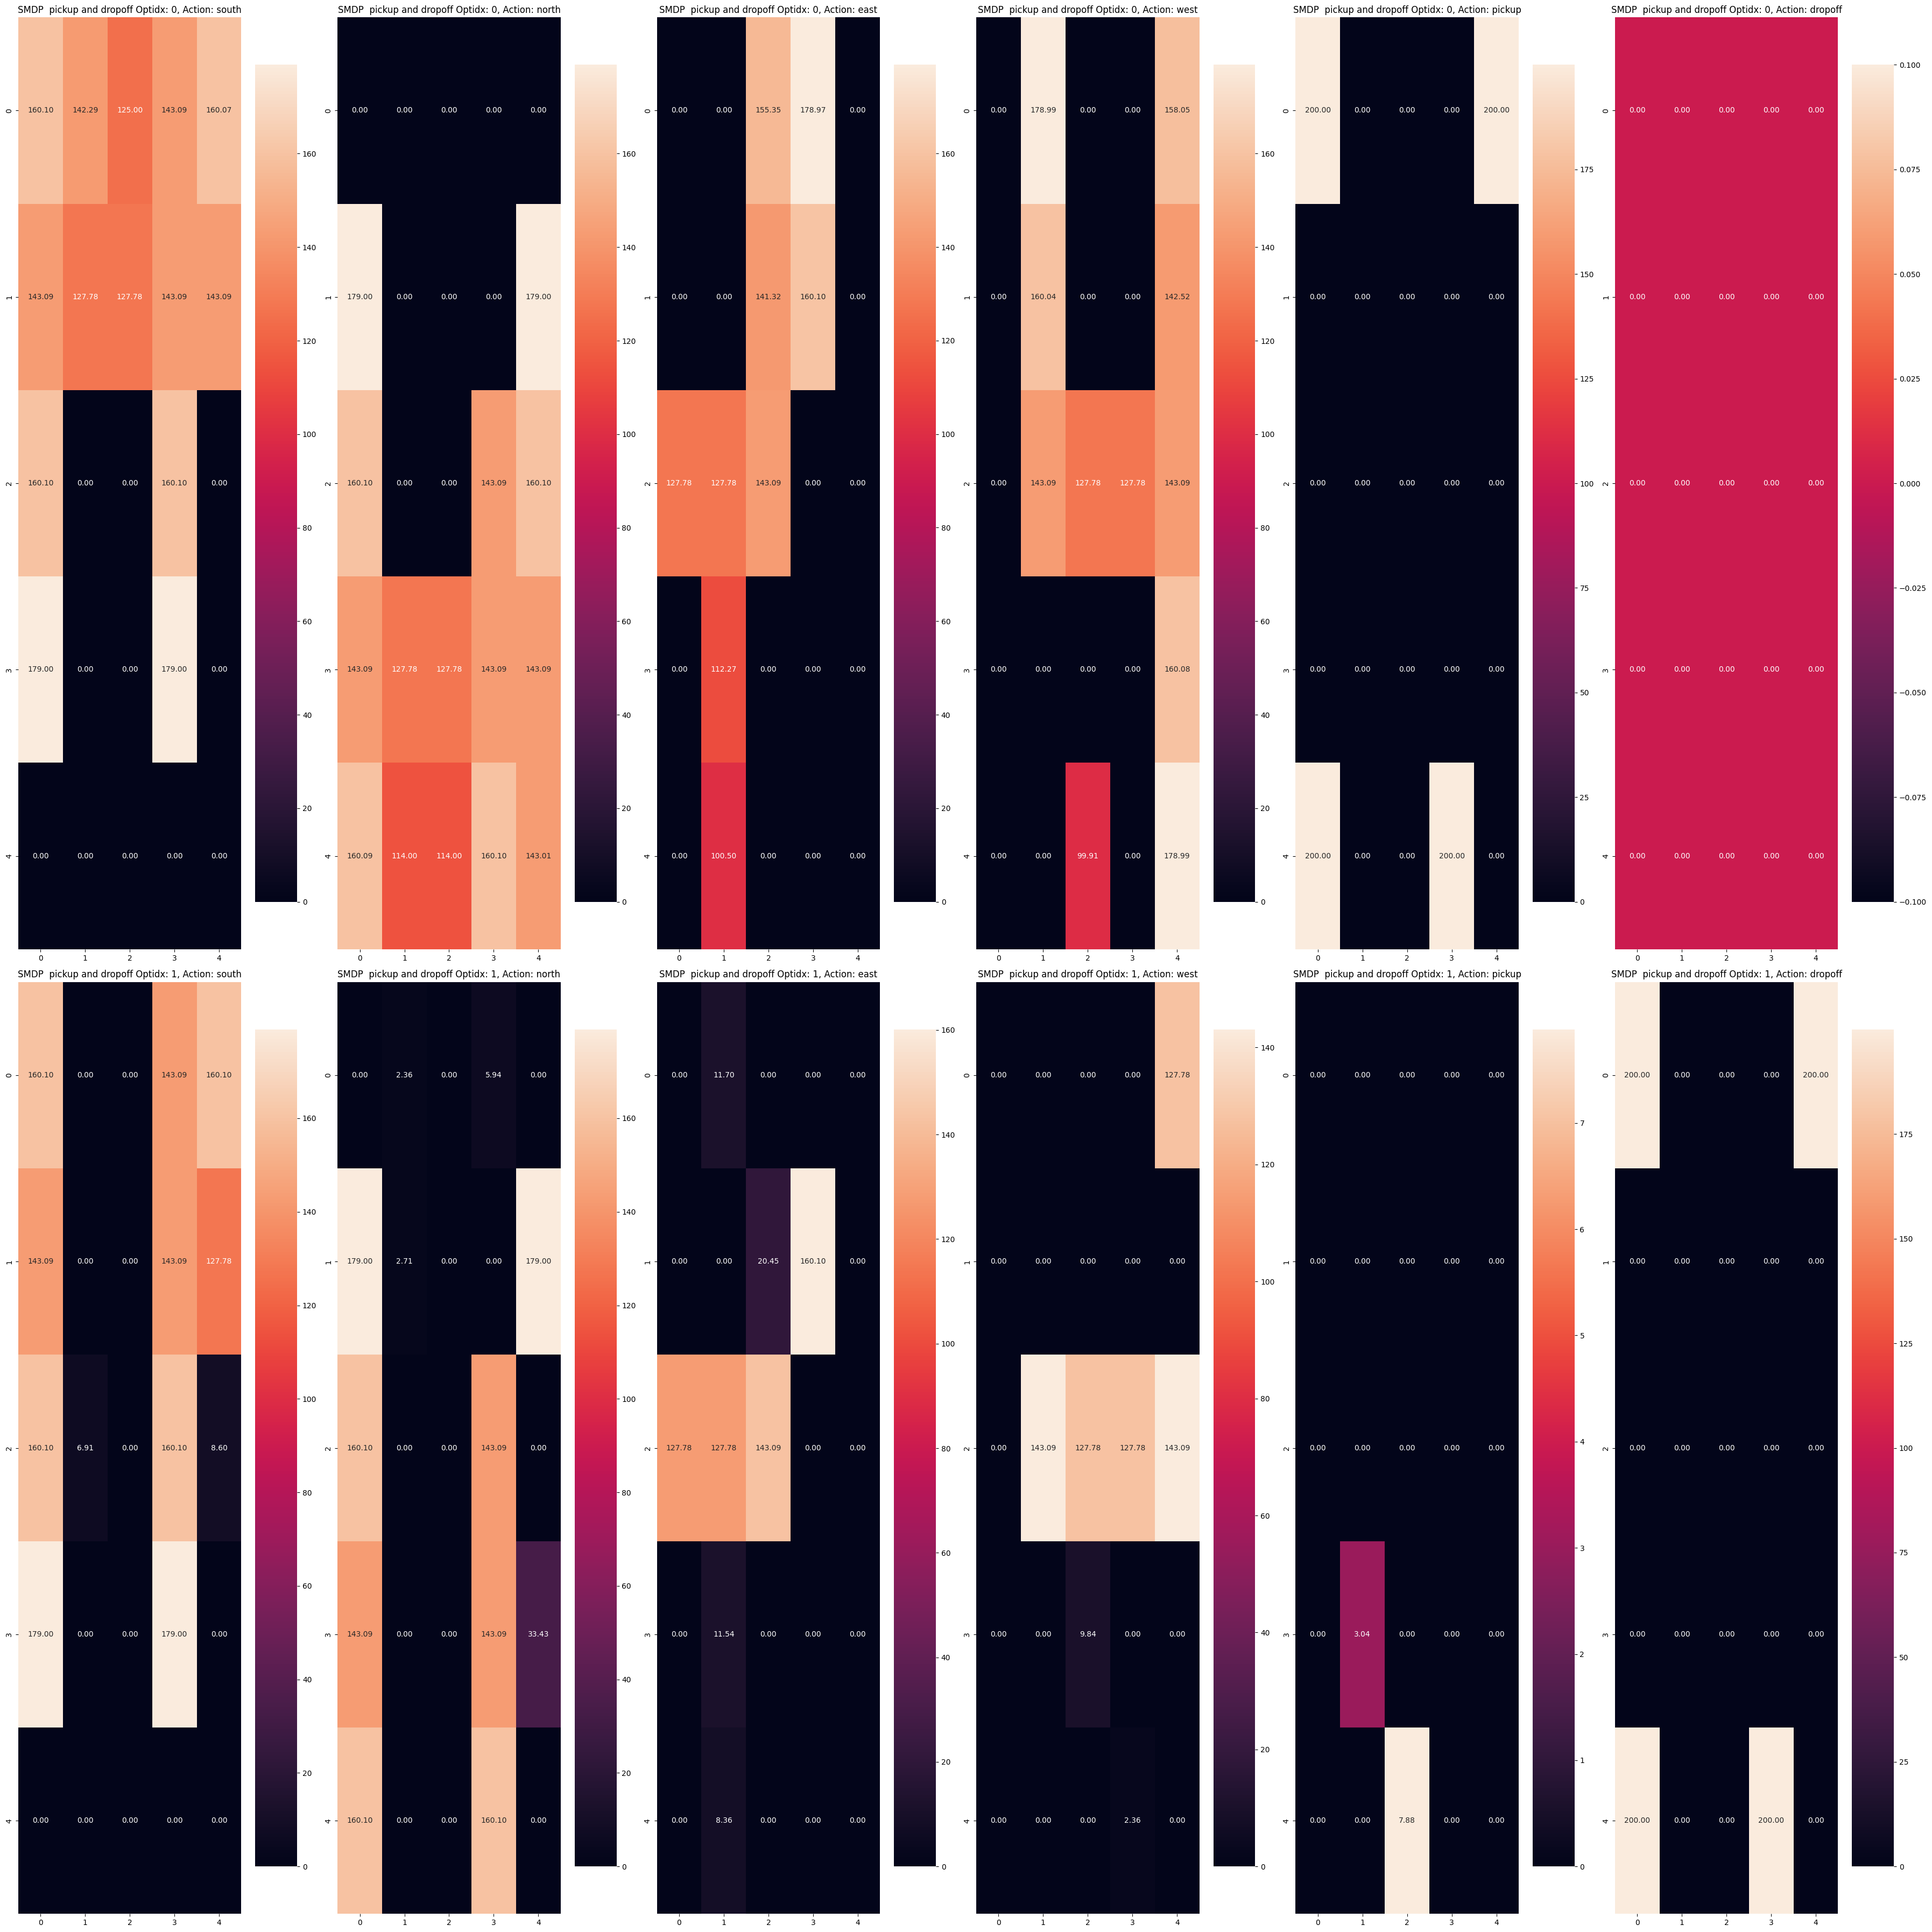

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

labels = {0:'south',1:'north', 2:'east', 3:'west', 4: 'pickup', 5: 'dropoff'}
action_names = ['south','north','east','west', 'pickup', 'dropoff']

fig, axs = plt.subplots(2, 6, figsize=(36, 36))

for optidx in range(2):
    actions = [Qopt[optidx][:, i].reshape(5,5) for i in range(6)]
    for i, ax in enumerate(axs[optidx]):
        sns.heatmap(actions[i], annot=True, fmt='.2f', ax=ax)
        ax.set_title(f'SMDP  pickup and dropoff Optidx: {optidx}, Action: {action_names[i]}')

plt.tight_layout()
plt.show()


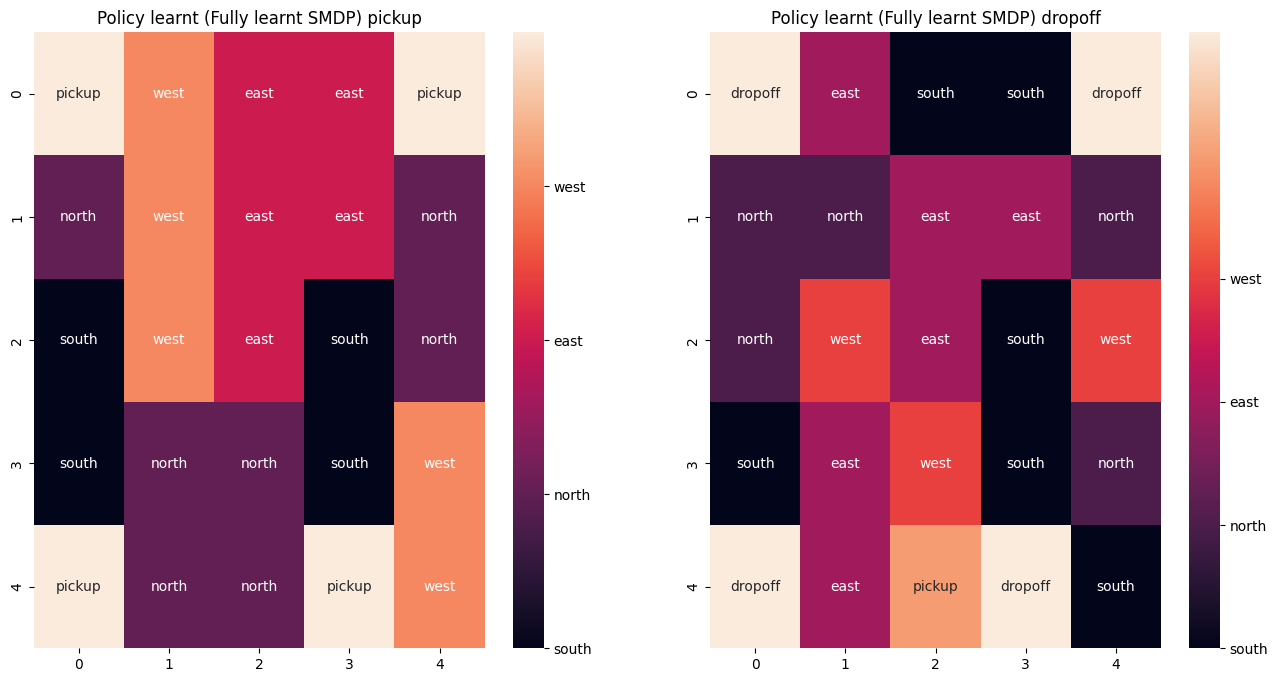

In [10]:
figure, axis = plt.subplots(1, 2, figsize=(16, 8))
for idx in range(2):
    labels = {0: 'south', 1: 'north', 2: 'east', 3: 'west', 4: 'pickup', 5: 'dropoff'}
    annot_text = np.vectorize(labels.get)(np.argmax(Qopt[idx], axis=1).reshape(5, 5))
    ax = sns.heatmap(np.argmax(Qopt[idx], axis=1).reshape(5, 5), ax=axis[idx], annot=annot_text, fmt='')
    axis[idx].set_title(f"Policy learnt (Fully learnt SMDP) {labels[idx + 4]}")
    c_bar = ax.collections[0].colorbar
    c_bar.set_ticks([i for i in range(4)])
    c_bar.set_ticklabels(['south', 'north', 'east', 'west'])
plt.show()


# IOQL (Pickup and drop option)

In [11]:
'''
A bunch of imports, you don't have to worry about these
'''
import random
import numpy as np
import random
import gymnasium as gym
import glob
import io
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML
from IPython.display import clear_output
import time

In [12]:
#Setting up the environment
env = gym.make('Taxi-v3')

env.reset()

#Current State
print(env.unwrapped.s)

# 5x5x5x4 grid = 500 states
print ("Number of states:", env.unwrapped.observation_space.n)

# Primitive Actions
action = ["south", "north", "east", "west","pick","drop"]
#correspond to [0,1,2,3,4,5] that's actually passed to the environment

# either go left, up, down or right
print ("Number of actions that an agent can take:", env.unwrapped.action_space.n)

# Example Transitions
rnd_action = random.randint(0, 3)
print ("Action taken:", action[rnd_action])
next_state, reward, is_terminal, t_prob, _ = env.step(rnd_action)
print ("Transition probability:", t_prob)
print ("Next state:", next_state)
print ("Reward recieved:", reward)
print ("Terminal state:", is_terminal)

state, _ = env.reset()
print ("Decoded state:", list(env.unwrapped.decode(state)))

331
Number of states: 500
Number of actions that an agent can take: 6
Action taken: east
Transition probability: False
Next state: 351
Reward recieved: -1
Terminal state: False
Decoded state: [1, 4, 0, 3]


In [13]:
policyOptionR = np.array([[1,3,0,0,0],
                 [1,3,0,0,0],
                 [1,3,3,3,3],
                 [1,1,1,1,1],
                 [1,1,1,1,1]
                 ])
policyOptionG = np.array([[0,0,2,2,1],
                 [0,0,2,2,1],
                 [2,2,2,1,1],
                 [1,2,1,1,1],
                 [1,2,1,1,1]
                 ])
policyOptionY = np.array([[0,3,0,0,0],
                          [0,3,0,0,0],
                          [0,3,3,3,3],
                          [0,1,1,1,3],
                          [0,1,3,1,3]
                          ])
policyOptionB = np.array([[0,0,0,0,3],
                          [0,0,0,0,3],
                          [2,2,2,0,3],
                          [1,1,1,0,3],
                          [1,1,1,0,3]
                          ])
policyOpt = [policyOptionR,policyOptionG,policyOptionY,policyOptionB]

In [14]:
# --- Option function for two options: pick and drop ---
def Option(env, state, Q, optionNum, eps=0.1):
    optdone = False
    x, y, pas, drop = env.unwrapped.decode(state)
    locs = env.unwrapped.locs

    if optionNum == 0:  # Pick option
        # If passenger is already in taxi (pas == 4), option is done
        if pas == 4:
            # print("Pickup option is done")
            optdone = True
            optact = egreedy_policy(Q[optionNum], 5*x + y, epsilon=eps)
        else:
            target = locs[pas]
            if (x, y) == target:
                optact = 4  # pick action
                optdone = True
            else:
                # print("drop = ", drop, "x = ", x, "y = ", y)
                optact = policyOpt[pas][x][y]
                # optact = egreedy_policy(Q[optionNum], 5*x + y, epsilon=eps)
    elif optionNum == 1:  # Drop option
        # If passenger is not in taxi, cannot drop
        if pas != 4:
            optdone = True
            optact = egreedy_policy(Q[optionNum], 5*x + y, epsilon=eps)
        else:
            target = locs[drop]
            if (x, y) == target:
                optact = 5  # drop action
                optdone = True
            else:
                # print("drop = ", drop, "x = ", x, "y = ", y)
                optact = policyOpt[drop][x][y]
                # optact = egreedy_policy(Q[optionNum], 5*x + y, epsilon=eps)
    else:
        raise ValueError("Invalid option number")
    return [optact, optdone]

# epsilon-greedy action selection function
def egreedy_policy(q_values,state,epsilon):
  if q_values[state].any() and random.random() > epsilon:
    #print('greedy', np.argmax(q_values[state]),q_values.shape)
    return np.argmax(q_values[state])
  choice = random.randint(0,q_values.shape[-1]-1)  
  #print('random',choice,q_values.shape)  
  return choice

In [15]:
#### Intra Option Q-Learning
from tqdm import tqdm

rewards3 = []
T = 1
goal = {0:[0,0],1:[0,4],2:[4,0],3:[4,3]}


# Add parameters you might need here
gamma = 0.9
alpha = 0.1
nO = 2 #number of options
nX = 5; nY = 5; nPas = 5; nDrop = 4
q_values_IOQL = np.zeros((nPas*nDrop,nO))
updates_IOQL = np.zeros((nPas*nDrop,nO))

Qopt = {i:np.zeros((env.unwrapped.observation_space.n//20,env.unwrapped.action_space.n)) for i in range(nO)} #Q-values for each option


eps = {i:0.01 for i in range(nO)}
eps_min = 0.01
eps_decay = 0.99
eps_main = 0.5

count = 0
Neps = 5000

def Sub(state, nPas = nPas, nDrop = nDrop):
  _,_,pas,drop = env.unwrapped.decode(state) 
  subState = nDrop*pas+drop 
  return subState 


# Iterate over Neps episodes
for i in tqdm(range(Neps)):
    state, _ = env.reset()    
    done = False
    tot_rew=0

    # While episode is not over
    while not done:
        
        # Choose action  
        _,_,pas,drop = env.unwrapped.decode(state) 
        subState = nDrop*pas+drop      
        action = egreedy_policy(q_values_IOQL, subState, epsilon=eps_main)
        eps_main = max(eps_min,eps_main*eps_decay)
        

        option = action
        optdone = False
        prev = state  
        while not optdone and not done:
            
            optact,optdone = Option(env,state,Qopt,option,eps[option])
            next_state, reward, terminated, truncated,_ = env.step(optact)
            done = terminated or truncated
            tot_rew+=reward

            
            #Option Policy Learning
            [x,y,_,_]=  list(env.unwrapped.decode(state)) 
            [x1,y1,_,_]=  list(env.unwrapped.decode(next_state)) 

            

            eps[option] = max(eps_min,eps_decay*eps[option])
            reward_surr = reward
            if optdone:
              reward_surr = 20
            # if optact<4:  
            Qopt[option][5*x+y, optact] = Qopt[option][5*x+y, optact] + alpha*(reward_surr + gamma*np.max(Qopt[option][5*x1+y1, :]) - Qopt[option][5*x+y, optact])



            #finding all options giving same action call
            
            for o in range(nO):
              optact_o,optdone_o = Option(env,state,Qopt,o,eps[o])
              if optact_o == optact:
                eps[o] = max(eps_min,eps_decay*eps[o])
                if optdone_o:
                  q_values_IOQL[Sub(state), o] += alpha*(reward + gamma*np.max(q_values_IOQL[Sub(next_state), :]) - q_values_IOQL[Sub(state), o])
                else:
                  q_values_IOQL[Sub(state), o] += alpha*(reward + gamma*q_values_IOQL[Sub(next_state), o] - q_values_IOQL[Sub(state), o]) 

                updates_IOQL[Sub(state), o] += 1
            state = next_state 
        
    rewards3.append(tot_rew)
    x,y,pas,drop = env.unwrapped.decode(state)
    if pas==drop:
      count+=1
      clear_output(wait=True)
      # print('Success ({}/{}) = {}%'.format(count,i+1,100*count/(i+1)))
 
        

100%|██████████| 5000/5000 [00:07<00:00, 706.59it/s]


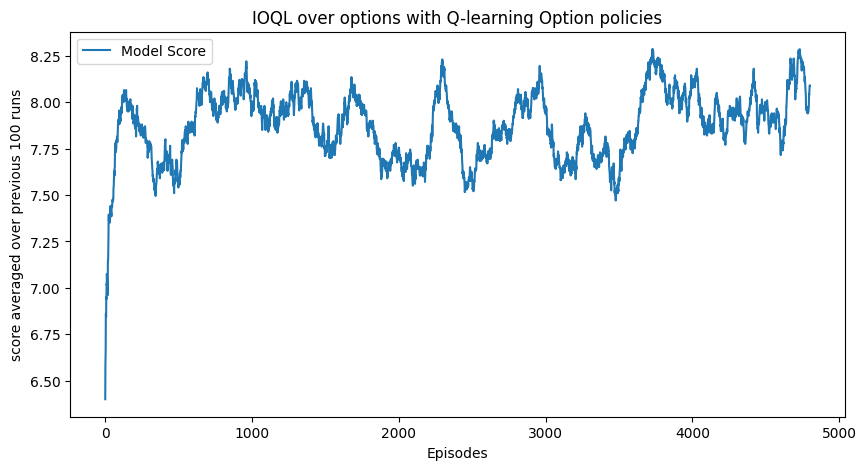

In [16]:
plt.figure(figsize = (10,5))
avg_rews3 = [np.average(rewards3[i:i+200]) for i in range(len(rewards3)-200)]
plt.plot(avg_rews3,label = 'Model Score')
plt.xlabel('Episodes')
plt.ylabel('score averaged over previous 100 runs')
plt.title('IOQL over options with Q-learning Option policies')
plt.legend()

Text(0.5, 1.0, 'Option learnt by IOQL (pickup and dropoff)')

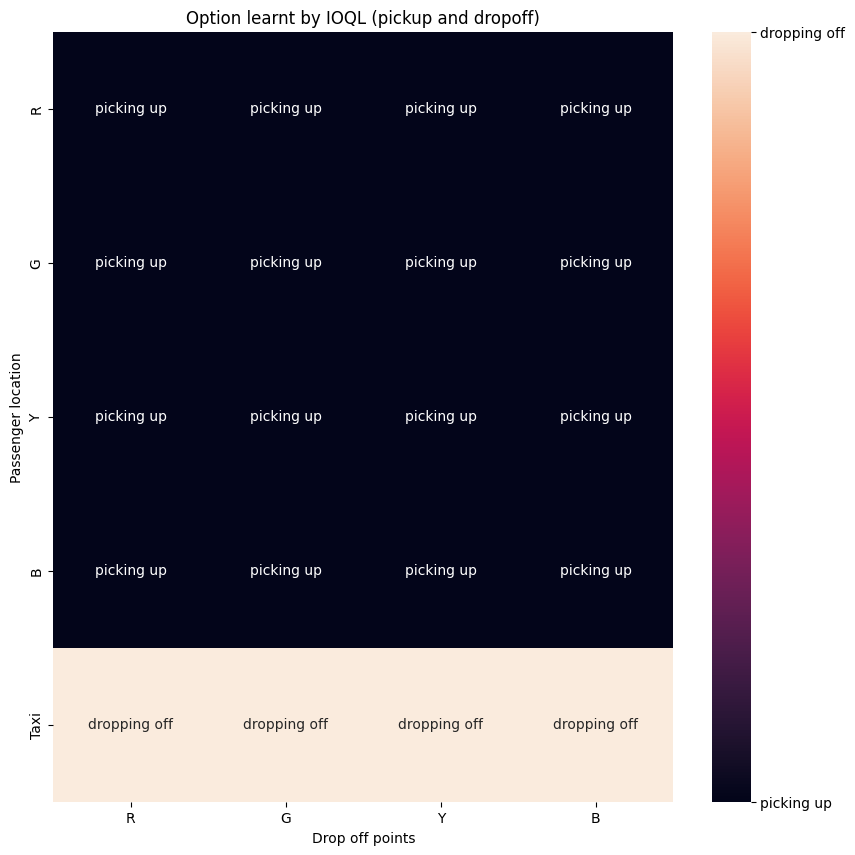

In [17]:
Qmax_IOQL = np.argmax(q_values_IOQL,axis = 1).reshape(5,4)
labels = {0:'picking up',1:'dropping off'}
annot_text = np.vectorize(labels.get)(Qmax_IOQL)
figure, axis = plt.subplots(1, 1,figsize=(10,10))
ax = sns.heatmap(Qmax_IOQL,ax=axis,xticklabels = ["R","G","Y","B"],yticklabels = ['R','G','Y','B','Taxi'],annot = annot_text,fmt = '')
c_bar = ax.collections[0].colorbar
c_bar.set_ticks([0, 1])
c_bar.set_ticklabels(['picking up','dropping off'])

axis.set_xlabel('Drop off points')
axis.set_ylabel("Passenger location")
axis.set_title('Option learnt by IOQL (pickup and dropoff)')

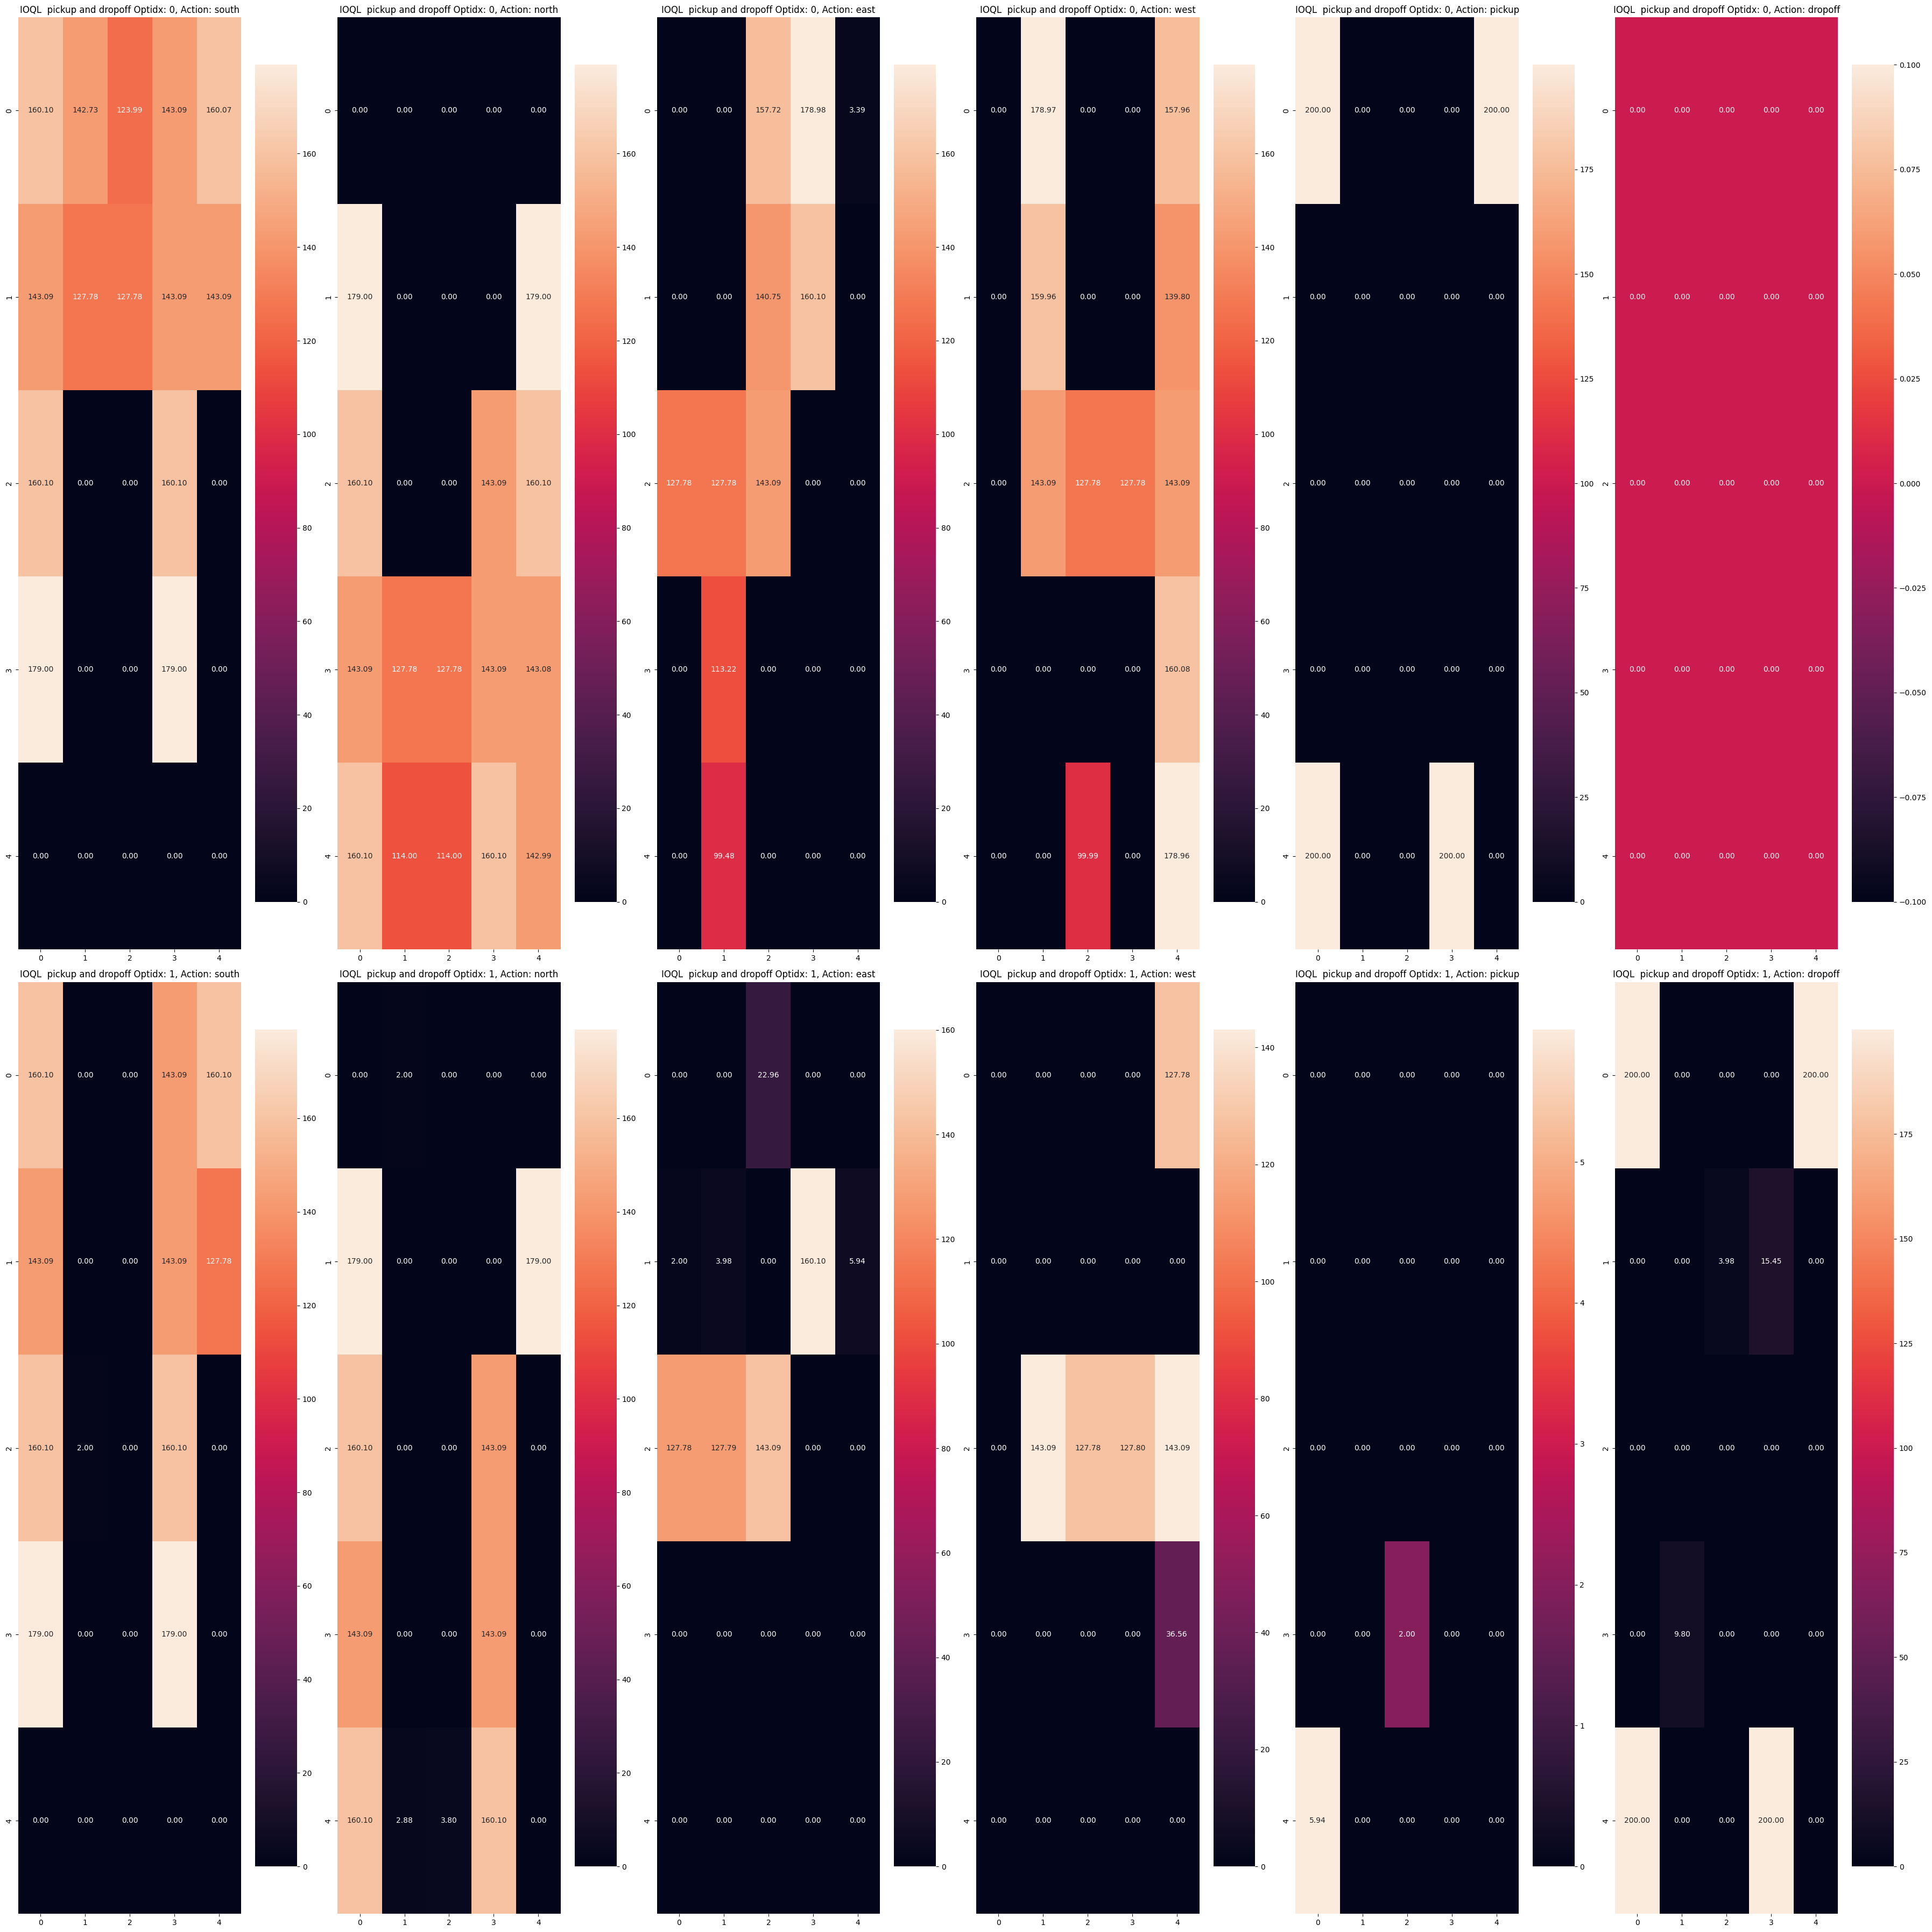

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

labels = {0:'south',1:'north', 2:'east', 3:'west', 4: 'pickup', 5: 'dropoff'}
action_names = ['south','north','east','west', 'pickup', 'dropoff']

fig, axs = plt.subplots(2, 6, figsize=(36, 36))

for optidx in range(2):
    actions = [Qopt[optidx][:, i].reshape(5,5) for i in range(6)]
    for i, ax in enumerate(axs[optidx]):
        sns.heatmap(actions[i], annot=True, fmt='.2f', ax=ax)
        ax.set_title(f'IOQL  pickup and dropoff Optidx: {optidx}, Action: {action_names[i]}')

plt.tight_layout()
plt.show()

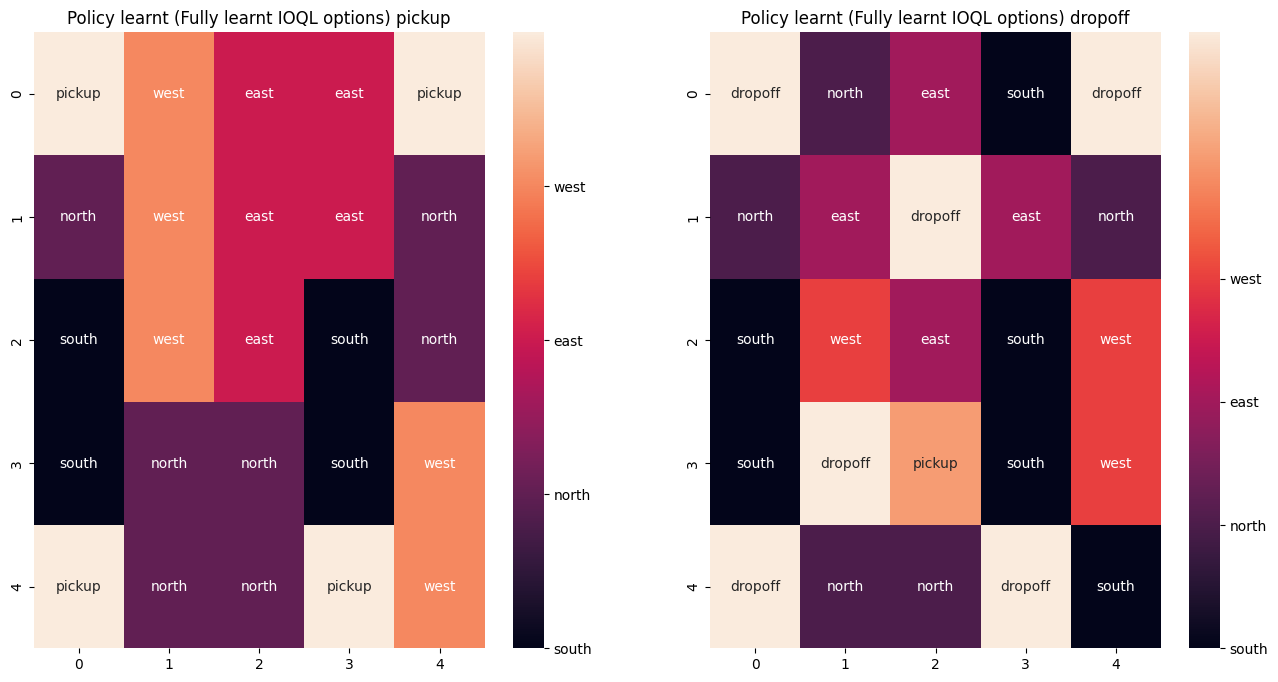

In [19]:
figure, axis = plt.subplots(1, 2, figsize=(16, 8))
for idx in range(2):
    labels = {0: 'south', 1: 'north', 2: 'east', 3: 'west', 4: 'pickup', 5: 'dropoff'}
    annot_text = np.vectorize(labels.get)(np.argmax(Qopt[idx], axis=1).reshape(5, 5))
    ax = sns.heatmap(np.argmax(Qopt[idx], axis=1).reshape(5, 5), ax=axis[idx], annot=annot_text, fmt='')
    axis[idx].set_title(f"Policy learnt (Fully learnt IOQL options) {labels[idx + 4]}")
    c_bar = ax.collections[0].colorbar
    c_bar.set_ticks([i for i in range(4)])
    c_bar.set_ticklabels(['south', 'north', 'east', 'west'])
plt.show()

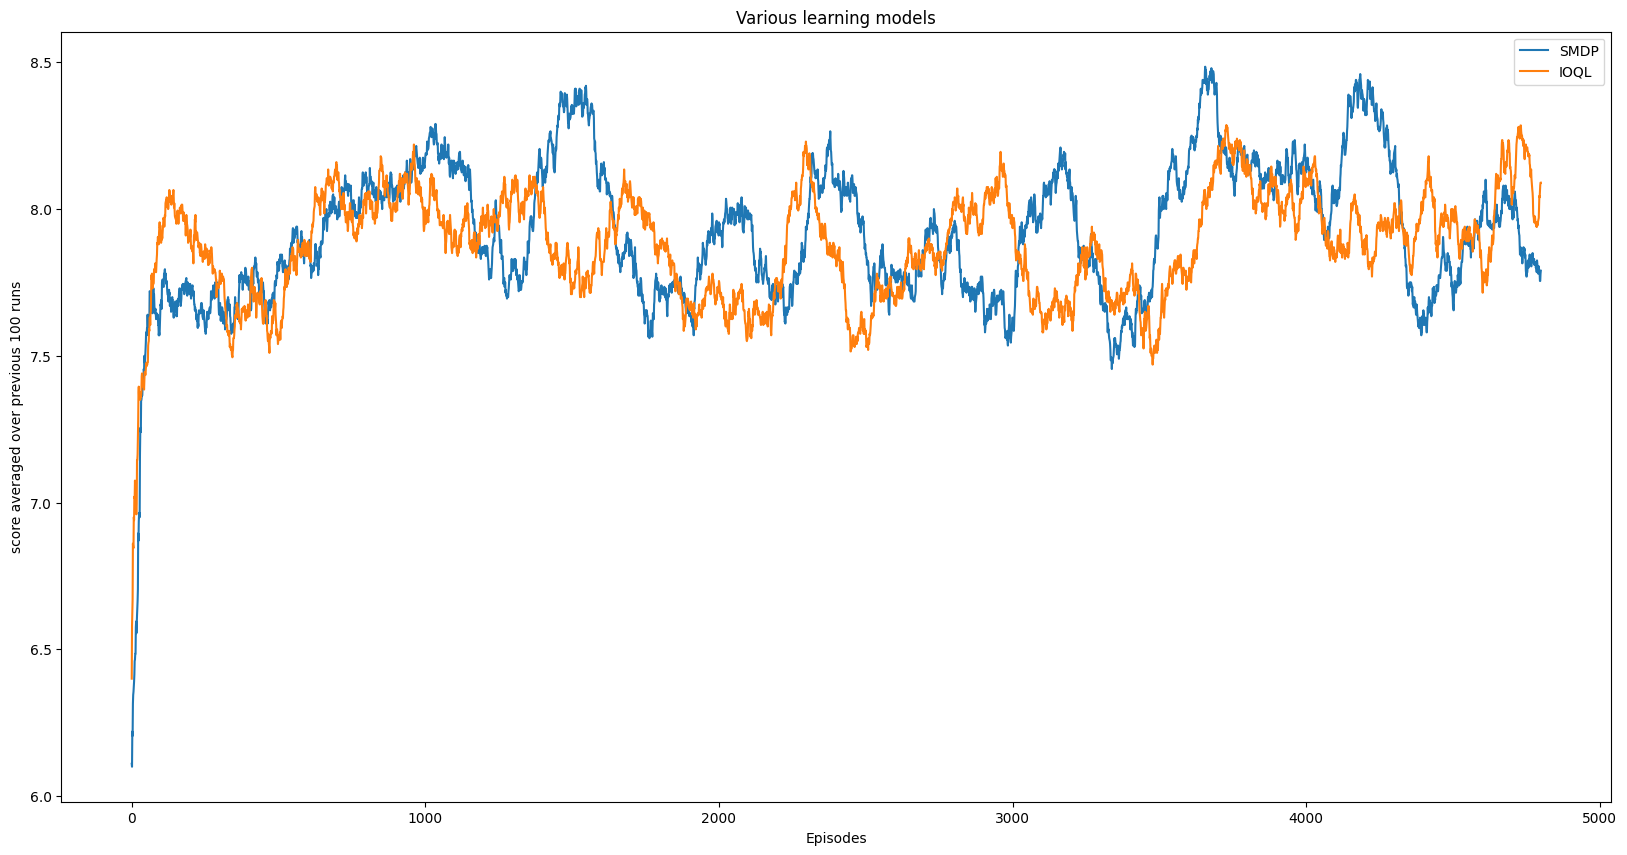

In [20]:
plt.figure(figsize = (20,10))
plt.plot(avg_rews4,label = 'SMDP')
plt.plot(avg_rews3,label = 'IOQL')
plt.xlabel('Episodes')
plt.ylabel('score averaged over previous 100 runs')
plt.title('Various learning models')
plt.legend()